In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
import os
from tqdm import tqdm
from util import ProcessMatrices

composers = ['beethoven', 'haydn', 'mozart']
stats = dict(zip(composers, [{}, {}, {}]))

main_path = "midis/"
mats_path = "mats/"

corrupted_files = []

for composer in composers:
    comp_path = os.path.join(main_path, composer)
    for f in tqdm(os.listdir(comp_path)):
        try:
            eng.probs(os.path.join(comp_path, f), mats_path, nargout=1)
            
            stats[composer][f] = ProcessMatrices(mats_path)
            
        except:
            corrupted_files.append(f)

print(corrupted_files)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:02<00:00,  1.55s/it]

['Be18n3m2.mid', 'Be18n3m3.mid', 'Be74m4.mid', 'H55n1m1.mid', 'H64n2m4.mid', 'H64n3m1.mid', 'H64n3m4.mid', 'H71n2m1.mid', 'H76n3m4.mid', 'MK464m2.mid', 'MK589m3.mid', 'MK590m2.mid']


In [3]:
genres = dict(zip(composers, [{}, {}, {}]))
names_for_genres = dict(zip(composers, [{}, {}, {}]))


with open("html/Be.htm", "r") as f:
    file = f.read()
    search='href="MIDIfiles/Beethoven/BeethovenSQ/'
    while True:
        file = file[file.find(search) + len(search):]
        if file[0:9] != 'Beethoven':
            break
        name, genre = file.split('/')[1].split('\"')[0:2]
        name = name[:-3] + 'mid'
        if name in corrupted_files:
            continue
        genre=genre.split('&')[0].replace('<', '').replace('>', '').replace('\n', '').strip()
        genres['beethoven'][name] = genre
        names_for_genres['beethoven'][genre] = names_for_genres['beethoven'].get(genre, set()).union(set([name]))


with open("html/Ha.htm", "r") as f:
    file = f.read()
    search='href="MIDIfiles/Haydn/HaydnSQ/'
    while True:
        file = file[file.find(search) + len(search):]
        if file[0:5] != 'Haydn':
            break
        name, genre = file.split('/')[1].split('\"')[0:2]
        name = name[:-3] + 'mid'
        if name in corrupted_files:
            continue
        genre=genre.split('&')[0].replace('<', '').replace('>', '').replace('\n', '').strip()
        genres['haydn'][name] = genre
        names_for_genres['haydn'][genre] = names_for_genres['haydn'].get(genre, set()).union(set([name]))

        
with open("html/Mo.htm", "r") as f:
    file = f.read()
    search='href="MIDIfiles/Mozart/MozartSQ/'
    while True:
        file = file[file.find(search) + len(search):]
        if file[0:6] != 'Mozart':
            break
        name, genre = file.split('/')[1].split('\"')[0:2]
        name = name[:-3] + 'mid'
        if name in corrupted_files:
            continue
        genre=genre.split('&')[0].replace('<', '').replace('>', '').replace('\n', '').strip()
        genres['mozart'][name] = genre
        names_for_genres['mozart'][genre] = names_for_genres['mozart'].get(genre, set()).union(set([name]))

In [4]:
import numpy as np

gen = 'Andante'

gen_names = dict(zip(composers, map(lambda x: sorted(list(names_for_genres[x][gen])), composers)))
gen_beethoven = np.array(list(map(lambda x: stats['beethoven'][x], gen_names['beethoven'])))
gen_mozart = np.array(list(map(lambda x: stats['mozart'][x], gen_names['mozart'])))
gen_haydn = np.array(list(map(lambda x: stats['haydn'][x], gen_names['haydn'])))

from sklearn.decomposition import PCA

gen_all = np.concatenate([gen_beethoven, gen_mozart, gen_haydn], axis=0)
pca = PCA(2)
pca.fit(gen_all)

pca_beethoven = pca.transform(gen_beethoven)
pca_mozart = pca.transform(gen_mozart)
pca_haydn = pca.transform(gen_haydn)

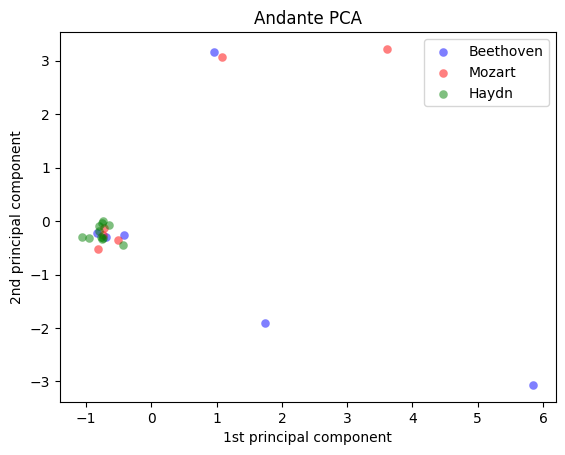

In [5]:
import matplotlib.pyplot as plt

plt.scatter(pca_beethoven[:,0], pca_beethoven[:,1], c='blue', label='Beethoven', linewidth=0.1, alpha=0.5)
plt.scatter(pca_mozart[:,0], pca_mozart[:,1], c='red', label='Mozart', linewidth=0.1, alpha=0.5)
plt.scatter(pca_haydn[:,0], pca_haydn[:,1], c='green', label='Haydn', linewidth=0.1, alpha=0.5)

plt.legend()
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.title(f'{gen} PCA');

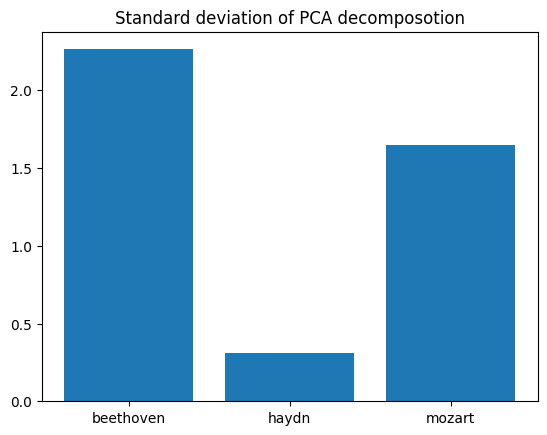

In [6]:
plt.bar(composers, [np.std(pca_beethoven), np.std(pca_haydn), np.std(pca_mozart)])
plt.title('Standard deviation of PCA decomposotion');

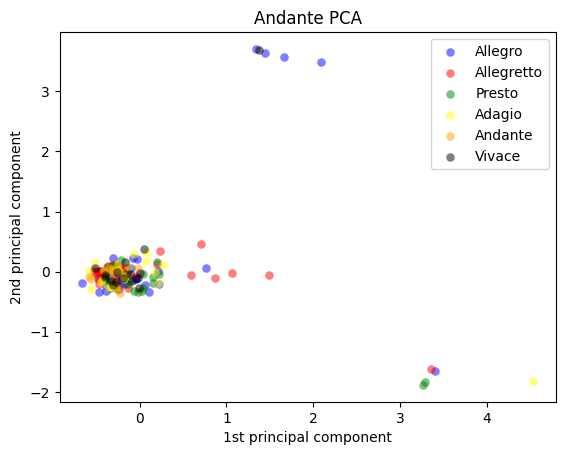

In [8]:
genres_haydn = ['Allegro', 'Allegretto', 'Presto', 'Adagio', 'Andante', 'Vivace']
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black']

genres_arr = []
for genre in genres_haydn:
    genres_arr.append(np.array(list(map(lambda x: stats['haydn'][x], names_for_genres['haydn'][genre]))))

gen_haydn_all = np.concatenate(genres_arr, axis=0)
pca_haydn = PCA(2)
pca_haydn.fit(gen_haydn_all)

pca_arr = list(map(pca_haydn.transform, genres_arr))
for i in range(len(genres_haydn)):
    plt.scatter(pca_arr[i][:,0], pca_arr[i][:,1], c=colors[i], label=genres_haydn[i], linewidth=0.1, alpha=0.5)

plt.legend()
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.title(f'{gen} PCA');

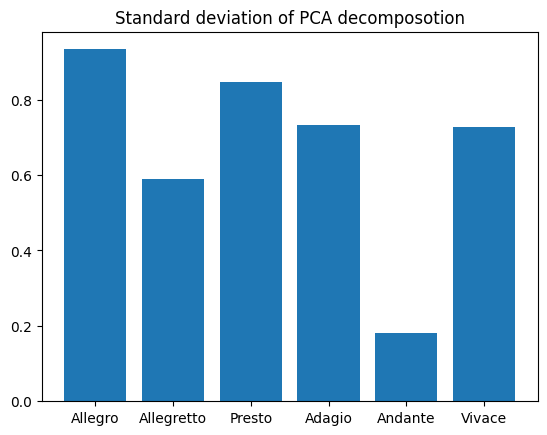

In [9]:
plt.bar(genres_haydn, list(map(np.std, pca_arr)))
plt.title('Standard deviation of PCA decomposotion');